<a href="https://colab.research.google.com/github/halcy/LearningJAX/blob/main/JAX_Day_2_Evening_Diffusion_beginnings.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# JAX Day 2 - Evening - Lets try diffusion, a bit

The ultimate goal here was to train a simple diffusion model on a TPU, so lets go towards that.

In [1]:
# Catchall "what is this runtime" cell
!nvidia-smi
GPU = !nvidia_smi

if len(GPU) > 3:
    GPU = True
else:
    GPU = False

!vmstat
print("")

import os

if "COLAB_TPU_ADDR" in os.environ:
    from tensorflow.python.profiler import profiler_client
    print("tpu:", os.environ['COLAB_TPU_ADDR'])
    tpu_profile_service_address = os.environ['COLAB_TPU_ADDR'].replace('8470', '8466')
    print(profiler_client.monitor(tpu_profile_service_address, 100, 2).strip())
    TPU = True
else:
    print("tpu: no")
    TPU = False

CPUS = os.cpu_count()
print("\ncpus:", CPUS)

NVIDIA-SMI has failed because it couldn't communicate with the NVIDIA driver. Make sure that the latest NVIDIA driver is installed and running.

procs -----------memory---------- ---swap-- -----io---- -system-- ------cpu-----
 r  b   swpd   free   buff  cache   si   so    bi    bo   in   cs us sy id wa st
 0  1      0 10688840  87972 2034456    0    0   828    15  176  330  2  1 96  1  0

tpu: 10.81.66.170:8470
Timestamp: 06:28:58
  TPU type: TPU v2
  Utilization of TPU Matrix Units (higher is better): 0.000%

cpus: 2


# Basic setup

Instead of Haiku, we'll try flax this time

In [2]:
# Set JAX, flax and optax up for the TPU
!pip install --upgrade -q jax jaxlib optax tqdm
!pip install --upgrade flax

import requests
import os

if 'TPU_DRIVER_MODE' not in globals():
    url = 'http://' + os.environ['COLAB_TPU_ADDR'].split(':')[0] + ':8475/requestversion/tpu_driver_nightly'
    resp = requests.post(url)
    TPU_DRIVER_MODE = 1

# TPU driver as backend for JAX
from jax.config import config
config.FLAGS.jax_xla_backend = "tpu_driver"
config.FLAGS.jax_backend_target = "grpc://" + os.environ['COLAB_TPU_ADDR']

     |████████████████████████████████| 708 kB 5.3 MB/s 
     |████████████████████████████████| 118 kB 49.5 MB/s 
     |████████████████████████████████| 76 kB 4.1 MB/s 
     |████████████████████████████████| 57 kB 5.1 MB/s 
     |████████████████████████████████| 183 kB 6.7 MB/s 


In [3]:
%matplotlib inline

import matplotlib.pyplot as plt
import numpy as np

import jax
import jax.numpy as jnp
from jax import jit, lax
from jax import nn as jnn
from jax import random as jr

import flax.linen as nn
from flax.core import freeze, unfreeze

from typing import Any, Callable, Sequence, Optional

from jax.experimental.maps import xmap, mesh
from jax.experimental.pjit import pjit, PartitionSpec
from jax.experimental import stax

import optax
import tqdm

# Pinky promise: We are now aware xmap is experimental, and will adjust our expectations accordingly
import warnings
warnings.filterwarnings("ignore", message="xmap is an experimental feature and probably has bugs!")

In [4]:
# Generate PRNG state
prng = jr.PRNGKey(23)

In [5]:
# Lets get MNIST
import tensorflow_datasets as tfds

data_dir = '/tmp/tfds'

# Fetch full datasets for evaluation
mnist_data, info = tfds.load(name="mnist", batch_size=-1, data_dir=data_dir, with_info=True)
mnist_data = tfds.as_numpy(mnist_data)
train_data, test_data = mnist_data['train'], mnist_data['test']
num_labels = info.features['label'].num_classes
h, w, c = info.features['image'].shape
num_pixels = h * w * c

# Full train set
train_images, train_labels = train_data['image'], train_data['label']
train_labels = jnn.one_hot(train_labels, num_labels)
train_images = jnp.array(train_images.astype(jnp.float32)) # One change here: We're explicitly converting to a jax array

# Full test set
test_images, test_labels = test_data['image'], test_data['label']
test_labels = jnn.one_hot(test_labels, num_labels)
test_images = jnp.array(test_images.astype(jnp.float32)) # Same here

local data directory. If you'd instead prefer to read directly from our public
GCS bucket (recommended if you're running on GCP), you can instead pass
`try_gcs=True` to `tfds.load` or set `data_dir=gs://tfds-data/datasets`.



Dl Completed...:   0%|          | 0/4 [00:00<?, ? file/s]


Dataset mnist downloaded and prepared to /tmp/tfds/mnist/3.0.1. Subsequent calls will reuse this data.


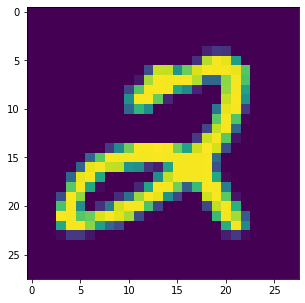

In [6]:
plt.figure(figsize=(5, 5))
plt.imshow(test_images[0,:,:,0], interpolation=None)

# Time to start implementing blocks for a diffusion model

In [7]:
class TimeEmbed(nn.Module):
    """
    Timestep embedding module
    """
    time_embed_dim: int

    @nn.compact
    def __call__(self, x):
        x = nn.Dense(self.time_embed_dim)(x)
        x = nn.silu(x)
        x = nn.Dense(self.time_embed_dim)(x)
        return x

class TimestepBlock(nn.Module):
    """
    Interface for modules that can take timestep embeddings as input
    in addition to regular embeddings.
    """
    def __call__(self, x, emb):
        pass

class TimestepEmbedSequential(TimestepBlock):
    """
    Block that passes timestep embeddings to all submodules that
    want them.

    Also works as a regular sequential type module
    """
    layers: Sequence[nn.Module]

    @nn.compact
    def __call__(self, x, emb = None):
        for layer in self.layers:
            if isinstance(layer, TimestepBlock):
                x = layer(x, emb)
            else:
                x = layer(x)
        return x

class TimestepBlockTest(TimestepBlock):
    """
    Dummy block for testing
    """
    @nn.compact
    def __call__(self, x, emb):
        return x

class ConvND(nn.Module):
    """
    n-D convolution with square kernel
    """
    dims: int
    out_channels: int
    kernel_size: int
    stride: int = 1
    padding: int = 'SAME'

    def setup(self):
        self.kernel = tuple([self.kernel_size] * self.dims)
        self.strides = tuple([self.stride] * self.dims)
        if self.padding in ['SAME', 'VALID']:
            self.paddings = self.padding
        else:
            self.paddings = tuple([(self.padding, self.padding)] * self.dims)
        self.conv = nn.Conv(self.out_channels, self.kernel, self.strides, self.paddings)

    def __call__(self, x):
        return self.conv(x)

class AvgND(nn.Module):
    """
    n-D average pooling with square window

    Numeric padding is NOT supported, specify either SAME or VALID padding.
    """
    dims: int
    window_size: int = 2
    stride: int = 2
    padding: int = 'SAME'

    def setup(self):
        self.window = [1] + [self.window_size] * self.dims
        self.strides = [1] + [self.stride] * self.dims
        if self.padding in ['SAME', 'VALID']:
            self.paddings = self.padding

    def __call__(self, x):
        full_window = tuple(list(self.window) + list([1] * (len(x.shape) - len(self.window) - 1)))
        full_strides = tuple(list(self.strides) + list([1] * (len(x.shape) - len(self.window) - 1)))
        return nn.avg_pool(x, full_window, full_strides, self.paddings)

class Identity(nn.Module):
  """
  For model building convenience, a class that does nothing
  """
  @nn.compact
  def __call__(self, x):
      return x

class Scale2X(nn.Module):
  """
  nD 2x nearest neighbour scaling
  """
  dims: int
  
  @nn.compact
  def __call__(self, x):
      tile_arr = [1] + [2] * self.dims + [1] * (len(x.shape) - self.dims - 1)
      return jnp.tile(x, tile_arr)

class Upsample(nn.Module):
    """
    Upsampling layer, factor 2

    Nearest neighour (element repeating), optionally with a convolution afterwards.
    """
    dims: int
    out_channels: int = 0
    use_conv: bool = False

    def setup(self):
        self.scale = Scale2X(self.dims)
        if self.use_conv:
            assert self.out_channels != 0
            self.conv = ConvND(self.dims, self.out_channels, 3)
        else:
            self.conv = Identity()

    def __call__(self, x):
        x = self.scale(x)
        x = self.conv(x)
        return x

class Downsample(nn.Module):
    """
    Downsampling layer, factor 2

    Uses either average pooling (default) or a strided convolution.
    """
    dims: int
    out_channels: int = 0
    use_conv: bool = False

    def setup(self):
        self.scale = Scale2X(self.dims)
        if self.use_conv:
            assert self.out_channels != 0
            self.downsample = ConvND(self.dims, self.out_channels, 3, stride=2, padding=1)
        else:
            self.downsample = AvgND(self.dims)

    def __call__(self, x):
        x = self.downsample(x)
        return x

class ResBlock(TimestepBlock):
    """
    Residual block with timesteps
    """
    dims: int
    in_channels: int
    out_channels: int
    dropout: int
    use_conv: bool = False
    up: bool = False
    down: bool = False
    use_scale_shift_norm: bool = False

    def setup(self):
        # Initial normalization block
        self.in_block = TimestepEmbedSequential((
            nn.GroupNorm(),
            nn.silu,
        ))

        # Up/Downsampling block
        if self.up:
            self.h_upd = Upsample(self.dims) 
            self.x_upd = Upsample(self.dims)
        elif self.down:
            self.h_upd = Downsample(self.dims)
            self.x_upd = Downsample(self.dims)
        else:
            self.h_upd = self.x_upd = Identity()

        # Input convolution
        self.in_conv = ConvND(self.dims, self.out_channels, 3)

        # Embedding projection block
        self.embed_project = TimestepEmbedSequential((
            nn.silu,
            nn.Dense(2 * self.out_channels if self.use_scale_shift_norm else self.out_channels)
        ))

        # Actual layer stack
        self.out_norm = nn.GroupNorm()
        self.out_layers = TimestepEmbedSequential((
            nn.silu,
            nn.Dropout(self.dropout, deterministic=True), # TODO: This should be dynamic, for training. Right now it's a noop.
            ConvND(self.dims, self.out_channels, 3) # There was a zero initializer (?) here, it's gone now, sorry. Maybe not important.
        ))

        # Channel change for skip connection
        if self.out_channels == self.in_channels:
            self.skip_connection = Identity()
        elif self.use_conv:
            self.skip_connection = ConvND(self.dims, self.out_channels, 3)
        else:
            self.skip_connection = ConvND(self.dims, self.out_channels, 1)

    def __call__(self, x, emb):
        # For residual: Resample x
        x_res = self.x_upd(x)

        # Run x through input & up/downsample block
        x = self.in_block(x)
        x = self.h_upd(x)
        x = self.in_conv(x)
            
        # Project embedding and unsqueeze up to match shape of x
        emb_out = self.embed_project(emb.reshape(emb.shape[0], -1))
        emb_out = emb_out.reshape((emb_out.shape[0],) + tuple([1] * (len(x.shape) - len(emb_out.shape))) + (emb_out.shape[-1],))
        
        # Apply actual convolution
        if self.use_scale_shift_norm:
            scale = emb_out[..., :self.out_channels]
            shift = emb_out[..., self.out_channels:]
            x = self.out_norm(x) * (1 + scale) + shift
            x = self.out_layers(x)
        else:
            x = x + emb_out
            x = self.out_norm(x)
            x = self.out_layers(x)

        # Return residual
        return self.skip_connection(x_res) + x

In [8]:
# Lets see if it works
conv = ResBlock(2, 64, 128, .5, up=True, use_conv=False, use_scale_shift_norm=True)
conv_in = jnp.zeros((10, 20, 20, 64))
params = conv.init(prng, conv_in, conv_in)
conv.apply(params, conv_in, conv_in).shape

(10, 40, 40, 128)

In [9]:
# TODO: Actual UNet model class
def create_model(model_channels, channel_mult):
    # Timestep embedding
    time_embed_dim = model_channels * 4
    self.time_embed = TimeEmbed(time_embed_dim)

    # Input block
    input_block_out_channels = int(channel_mult[0] * model_channels)
    self.input_block = ConvND(dims, input_block_out_channels, 3, padding = 1)

# Next up
Tomorrow, we continue where we left off: Lets implement the whole unet, maybe train something!